In [36]:
import os
from typing import List, Dict
from pathlib import Path
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt 

# how many documents
data_root = Path('./data/dataset')


def load_json(filepath: os.PathLike)-> List[Dict]:
    with open(filepath, 'r') as f:
        return json.load(f)

800


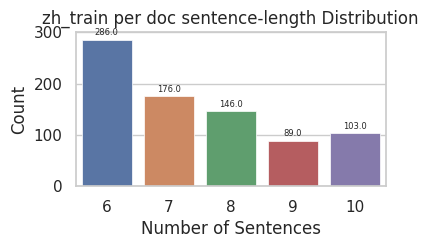

100


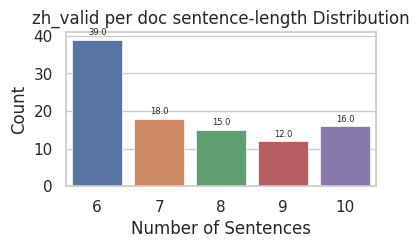

800


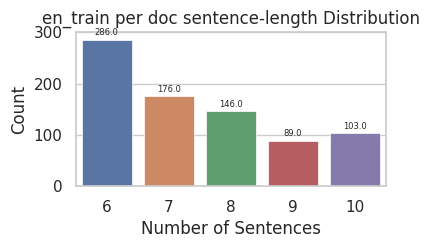

100


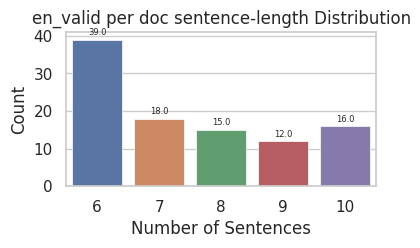

In [43]:

def get_length_distr(data: List[Dict], data_source: str):
    sent_counts = [len(doc['sentences']) for doc in data]
    sns.set(style='whitegrid')
    plt.figure(figsize=(4, 2))
    ax = sns.countplot(x=sent_counts, linewidth=0.5)
    
    # Annotate the label 
    for i, c in enumerate(ax.patches):
        ax.annotate(c.get_height(), (c.get_x() + c.get_width() / 2., c.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=6)

    # Customize the plot
    custom_title = f'{data_source} per doc sentence-length Distribution'
    ax.set(xlabel='Number of Sentences', ylabel='Count', title=custom_title) 
    # Show the plot
    # plt.tight_layout()
    plt.show()


for lang in ('zh', 'en'):
    for split in ('train', 'valid'):
        filepath = data_root / f'jsons_{lang}' / f'{split}.json'
        data = load_json(filepath)
        print(len(data))
        get_length_distr(data, f'{lang}_{split}')
        # use 4 subplots to show the distribution of sentence length


## Reconstruct the threads 
- use the replies column to get smaller threads 
- append the speaker to the front of the text 


In [38]:
# get 1 example
train_path = data_root / 'jsons_zh' / 'train.json'
train_json = load_json(train_path)
train_example = train_json[4]
from pprint import pprint 
pprint(train_example)

{'aspects': [[26, 28, '电池'],
             [60, 62, '电池'],
             [150, 152, '续航'],
             [169, 171, '续航'],
             [2, 4, '信号'],
             [5, 7, '电池'],
             [158, 160, '电池'],
             [81, 83, '续航'],
             [130, 134, '电池续航'],
             [50, 52, '电池']],
 'doc_id': '0007',
 'opinions': [[138, 143, '第一阶梯了', 'pos'],
              [8, 13, '是硬伤吗?', 'doubt'],
              [54, 56, '很弱', 'neg'],
              [175, 180, '还说硬伤?', 'pos'],
              [30, 38, '不是苹果的弱点了', 'pos'],
              [85, 87, '第一', 'pos'],
              [171, 173, '第一', 'pos'],
              [62, 67, '电掉太快了', 'neg'],
              [152, 154, '挺好', 'pos']],
 'replies': [-1, 0, 1, 2, 0, 0],
 'sentences': ['然 后 信 号 的 电 池 还 是 硬 伤 吗 ?',
               '苹 果 一 直 都 这 样 , 有 人 说 21 年 电 池 已 经 不 是 苹 果 的 弱 点 了 , 我 玩 我 姐 的 '
               '苹 果 手 机 感 觉 电 池 还 是 很 弱 [ 笑 cry ]',
               '电 池 电 掉 太 快 了 [ 允 悲 ]',
               '13 pro max 可 是 2021 旗 舰 手 机 续 航 测 试 第 一 的 啊 [ 汗 ]',
     

## Understanding indices 
- 先試試看直接 concatenate 成一個大的 string，然後 index

In [45]:
sentences = train_example['sentences']
full_text = ' '.join(sent for sent in sentences)
full_text = full_text.split()
# find the quads 
# 我太鬼了 
quads = train_example['triplets'] 
for quad in quads:
    assert len(quad) == 10 
    target_s, target_t = quad[0], quad[1] 
    asp_s, asp_t = quad[2], quad[3] 
    opn_s, opn_t = quad[4], quad[5]
    pol = quad[6]
    aspect_string = quad[7]
    target_string = quad[8]
    opn_string = quad[9]
    print(f'pol: {pol}')
    print(f'aspect_string: {aspect_string}')
    print(f'target_string: {target_string}')
    print(f'opn_string: {opn_string}')

    print(full_text[target_s:target_t])
    print(full_text[asp_s:asp_t])
    print(full_text[opn_s:opn_t])
    print('-----------------') 


pol: other
aspect_string: 13promax
target_string: 信号
opn_string: 是硬伤吗?
['13', 'promax']
['信', '号']
['是', '硬', '伤', '吗', '?']
-----------------
pol: other
aspect_string: 13promax
target_string: 电池
opn_string: 是硬伤吗?
['13', 'promax']
['电', '池']
['是', '硬', '伤', '吗', '?']
-----------------
pol: pos
aspect_string: 苹果
target_string: 电池
opn_string: 不是苹果的弱点了
['苹', '果']
['电', '池']
['不', '是', '苹', '果', '的', '弱', '点', '了']
-----------------
pol: neg
aspect_string: 苹果手机
target_string: 电池
opn_string: 很弱
['苹', '果', '手', '机']
['电', '池']
['很', '弱']
-----------------
pol: neg
aspect_string: 苹果手机
target_string: 电池
opn_string: 电掉太快了
['苹', '果', '手', '机']
['电', '池']
['电', '掉', '太', '快', '了']
-----------------
pol: pos
aspect_string: 13pro max
target_string: 续航
opn_string: 第一
['13', 'pro', 'max']
['续', '航']
['第', '一']
-----------------
pol: pos
aspect_string: iphone11 pro max
target_string: 电池续航
opn_string: 第一阶梯了
['iphone', '11', 'pro', 'max']
['电', '池', '续', '航']
['第', '一', '阶', '梯', '了']
-----------------


## Try construct annotation for sub-threads...?(pending)

In [39]:
import numpy as np 

class Node:
    def __init__(self, sent_id, parent_id=None, Max= 10):
        """One sentence -> A node 

        Parameters
        ----------
        sent_id : _type_
            _description_
        parent_id : _type_, optional
            _description_, by default None
        Max : int, optional
            _description_, by default 10
        """
        # max number of sentences
        # DiaASQ limits the number of sentences to 10  
        self.sent_id = sent_id
        self.parent_id = parent_id
        self.Max = Max
    # protect the sent_id property
    @property
    def sent_id(self):
        return self._sent_id
    @sent_id.setter 
    def sent_id(self, sent_id):
        self._sent_id = sent_id
    @property
    def parent(self):
        return self._parent
    @parent.setter
    def parent(self, parent_id):
        self._parent = parent_id


class ThreadTree(object): 
    def __init__(self, adj: List, root = 0):
        self.adj = adj 
        self.root = Node(0)
        self.index_d = [Node(sent_id = i, parent_id = -1) for i in range(len(adj))] # number of sentences 
    def build_tree(self):
        n = len(self.adj) 
        for parent_id in range(n):
            for child_id in self.adj[parent_id]:
                self.index_d[child_id].parent_id = parent_id
    def _construct_sub_threads(self):
        # for each node, trace back to its parent 
        # if the parent is -1, then it is the root
        # identify the tail of threads: node without child 
        self.sub_threads = [] 

        tail_nodes = [] # type: List[Node] 
        for node_i in range(len(self.adj)):
            children = self.adj[node_i]
            if len(children) == 0:
                tail_nodes.append(self.index_d[node_i])
        # for each tail node, trace back to its parent
        for tail_node in tail_nodes:
            sub_thread = [] 
            parent_id = tail_node.parent_id
            sub_thread.append(tail_node.sent_id)
            while parent_id != -1:
                sub_thread.append(parent_id)
                parent_id = self.index_d[parent_id].parent_id 
            sub_thread = sub_thread[::-1]
            self.sub_threads.append(sub_thread) 
    def get_sub_threads(self):
        self._construct_sub_threads()
        return self.sub_threads
        

In [40]:
def divide_by_reply_relation(data: List[Dict]):
    reply_relations = data['replies']
    sentences = data['sentences'] 
    # adj list 
    adj = [[] for _ in range(len(sentences))]
    for i, j in enumerate(reply_relations):
        # i replies to j, so j precedes i 
        if j == -1:
            continue
        assert j < i 
        adj[j].append(i) 
    
    # build the tree
    tree = ThreadTree(adj)
    tree.build_tree()
    sub_threads = tree.get_sub_threads()
    return sub_threads

divide_by_reply_relation(train_example)

        

[[0, 1, 2, 3], [0, 4], [0, 5]]

In [42]:
# reconstruct the thread using speaker name
# speaker name: index? character-based? 

def add_speaker_prefix(data: List[Dict]):
    # check number of speakers 
    #  'speakers': [0, 1, 2, 1, 3, 0, 4, 5, 0, 6], 
    speakers = data['speakers'] 
    n_speaker = len(set(speakers))
    assert n_speaker <= 26 # a better way is to convert 26 to AA, 27 to AB, etc.
    sentences = data['sentences'].copy() 
    sp_sent_pairs = zip(speakers, sentences)
    for i, (sp, sent) in enumerate(sp_sent_pairs):
        sp = chr(ord('@')+int(sp)+1)
        sent = f'{sp}: {sent}'
        sentences[i] = sent
    # display
    # pprint(sentences)
    data_copy = data.copy()
    del data 
    data_copy['sentences'] = sentences
    return data_copy 
        
# add_speaker_prefix(train_example)
    
def remove_space():
    # such that the texts look more natural 
    ... 

 
divisions = divide_by_reply_relation(train_example)
add_speaker_data = add_speaker_prefix(train_example)
for sub_thread_id,  sub_thread in enumerate(divisions):
    print(f'sub_thread: {sub_thread_id}')
    for i in sub_thread:
        print(add_speaker_data['sentences'][i])
    print('------------------')
    

sub_thread: 0
A: 然 后 信 号 的 电 池 还 是 硬 伤 吗 ?
B: 苹 果 一 直 都 这 样 , 有 人 说 21 年 电 池 已 经 不 是 苹 果 的 弱 点 了 , 我 玩 我 姐 的 苹 果 手 机 感 觉 电 池 还 是 很 弱 [ 笑 cry ]
C: 电 池 电 掉 太 快 了 [ 允 悲 ]
D: 13 pro max 可 是 2021 旗 舰 手 机 续 航 测 试 第 一 的 啊 [ 汗 ]
------------------
sub_thread: 1
A: 然 后 信 号 的 电 池 还 是 硬 伤 吗 ?
D: 所 以 苹 果 这 次 自 造 5 g 芯 片 就 是 为 了 解 决 信 号 问 题 吧 , 电 池 的 话 , 其 实 iphone 11 pro max 开 始 , 电 池 续 航 就 已 经 在 第 一 阶 梯 了 , 13 系 列 实 际 上 续 航 挺 好 的
------------------
sub_thread: 2
A: 然 后 信 号 的 电 池 还 是 硬 伤 吗 ?
E: 13 promax 的 电 池 你 用 了 吗 ? 所 有 手 机 续 航 第 一 , 你 还 说 硬 伤 ?
------------------
